In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator
import matplotlib.ticker as mtick
import os
import json
import sys
import datetime
from datetime import date
from matplotlib.dates import MO, WeekdayLocator, MonthLocator, YearLocator
from datetime import datetime, UTC, date
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter, MO

# Append utils to path for logo import
sys.path.append("utils")
from logo import add_logo

# Make the data on each chart today's date
def format_date_with_suffix(date_obj):
    day = date_obj.day
    # Determine the ordinal suffix
    if 10 <= day % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(day % 10, 'th')
    return date_obj.strftime(f"%B {day}{suffix}, %Y")

today = datetime.today()
date = format_date_with_suffix(today)

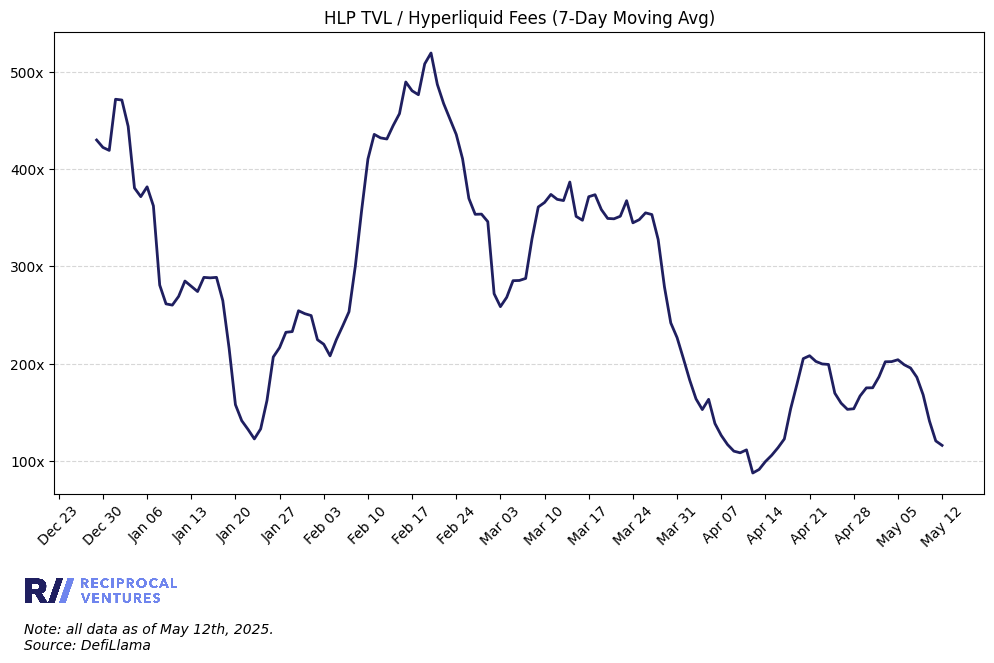

          date           tvl     fees  tvl-to-fees  tvl-to-fees-7d
130 2025-05-03  2.075779e+08   597229   347.568315      202.024628
131 2025-05-04  2.091957e+08   817513   255.892783      202.175631
132 2025-05-05  2.138452e+08  1464695   145.999816      204.112634
133 2025-05-06  2.179440e+08  1492495   146.026640      198.964646
134 2025-05-07  2.187163e+08  1767519   123.741987      195.632341
135 2025-05-08  2.182054e+08  2649191    82.366810      186.146966
136 2025-05-09  2.250618e+08  3015825    74.626933      168.031898
137 2025-05-10  2.373776e+08  1491492   159.154428      141.115628
138 2025-05-11  2.518477e+08  2233125   112.778129      120.670678
139 2025-05-12  2.609690e+08  2289695   113.975446      116.095768


In [10]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load HLP TVL data
with open("raw-data/defillama-raw-data/defillama_HLP.json", "r") as f:
    hlp_data = json.load(f)

hlp_raw = hlp_data["chainTvls"]["Hyperliquid"]["tvl"]
hlp_df = pd.DataFrame(hlp_raw)
hlp_df["date"] = pd.to_datetime(hlp_df["date"], unit="s")
hlp_df = hlp_df.rename(columns={"totalLiquidityUSD": "tvl"})
hlp_df = hlp_df[["date", "tvl"]]

# Merge datasets
df = pd.merge(hlp_df, fee_df, on="date", how="inner")
df["tvl-to-fees"] = df["tvl"] / df["fees"]

# Calculate trailing 7-day average
df["tvl-to-fees-7d"] = df["tvl-to-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["tvl-to-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_title("HLP TVL / Hyperliquid Fees (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}x'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/tvl-to-fees_ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "tvl", "fees", "tvl-to-fees", "tvl-to-fees-7d"]].tail(10))

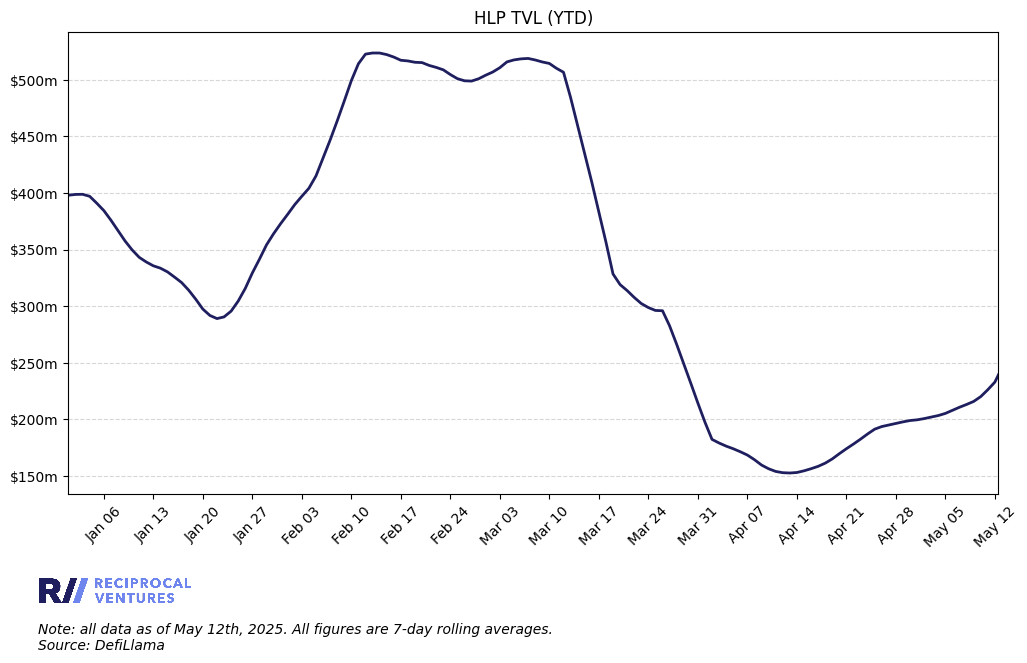

                   date           tvl        tvl-7d
154 2025-05-04 00:00:00  2.091957e+08  2.033344e+08
155 2025-05-05 00:00:00  2.138452e+08  2.052181e+08
156 2025-05-06 00:00:00  2.179440e+08  2.079712e+08
157 2025-05-07 00:00:00  2.187163e+08  2.106676e+08
158 2025-05-08 00:00:00  2.182054e+08  2.131263e+08
159 2025-05-09 00:00:00  2.250618e+08  2.157923e+08
160 2025-05-10 00:00:00  2.373776e+08  2.200494e+08
161 2025-05-11 00:00:00  2.518477e+08  2.261426e+08
162 2025-05-12 00:00:00  2.609690e+08  2.328745e+08
163 2025-05-12 12:12:35  2.635224e+08  2.393857e+08


In [11]:
# Load HLP TVL data
with open("raw-data/defillama-raw-data/defillama_HLP.json", "r") as f:
    hlp_data = json.load(f)

hlp_raw = hlp_data["chainTvls"]["Hyperliquid"]["tvl"]
hlp_df = pd.DataFrame(hlp_raw)
hlp_df["date"] = pd.to_datetime(hlp_df["date"], unit="s")
hlp_df = hlp_df.rename(columns={"totalLiquidityUSD": "tvl"})
hlp_df = hlp_df[["date", "tvl"]]

# Calculate trailing 7-day average
hlp_df['tvl-7d'] = hlp_df['tvl'].rolling(window=7).mean()

# Make data YTD
hlp_df = hlp_df[hlp_df['date'] >= '2025-01-01']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(hlp_df["date"], hlp_df["tvl-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.margins(x=0)

# Y-axis formatting
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1e6:,.0f}m'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

ax.set_title("HLP TVL (YTD)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. All figures are 7-day rolling averages.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hlp-tvl_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(hlp_df[["date", "tvl", "tvl-7d"]].tail(10))

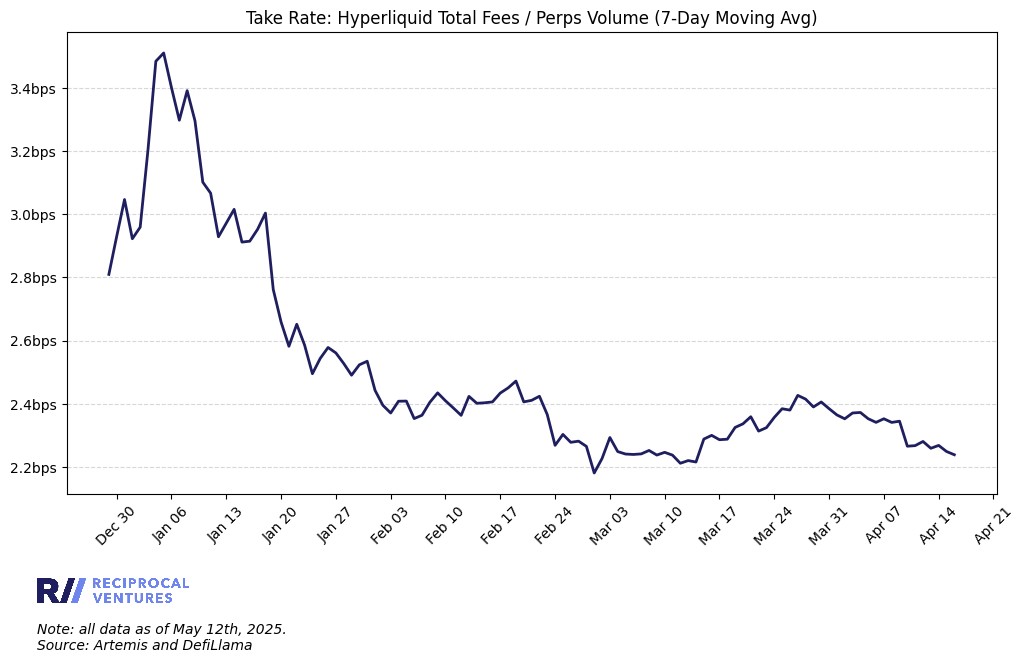

          date     fees  perps-volume  take-rate  take-rate-7d
105 2025-04-08  1746313  7.827351e+09   2.231040      2.340572
106 2025-04-09  2837027  1.270113e+10   2.233680      2.344451
107 2025-04-10  1686123  7.394696e+09   2.280179      2.265196
108 2025-04-11  1327396  5.731433e+09   2.315993      2.267029
109 2025-04-12  1164323  5.070751e+09   2.296155      2.280189
110 2025-04-13  1365048  6.333385e+09   2.155321      2.258602
111 2025-04-14  1491560  6.316587e+09   2.361339      2.267672
112 2025-04-15  1221402  5.825376e+09   2.096692      2.248480
113 2025-04-16  1508963  6.982591e+09   2.161036      2.238102
114 2025-04-17  1085608           NaN        NaN           NaN


In [12]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load Hyperliquid perps volume data
volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
volume_df['Date'] = pd.to_datetime(volume_df['Date'], format='%d-%b-%y')
volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(volume_df, fee_df, on="date", how="inner")
df["take-rate"] = df["fees"] / df["perps-volume"] * 10000  # Convert to BPS

# Calculate trailing 7-day average
df["take-rate-7d"] = df["take-rate"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["take-rate-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Take Rate: Hyperliquid Total Fees / Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}bps'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/take-rate_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "fees", "perps-volume", "take-rate", "take-rate-7d"]].tail(10))


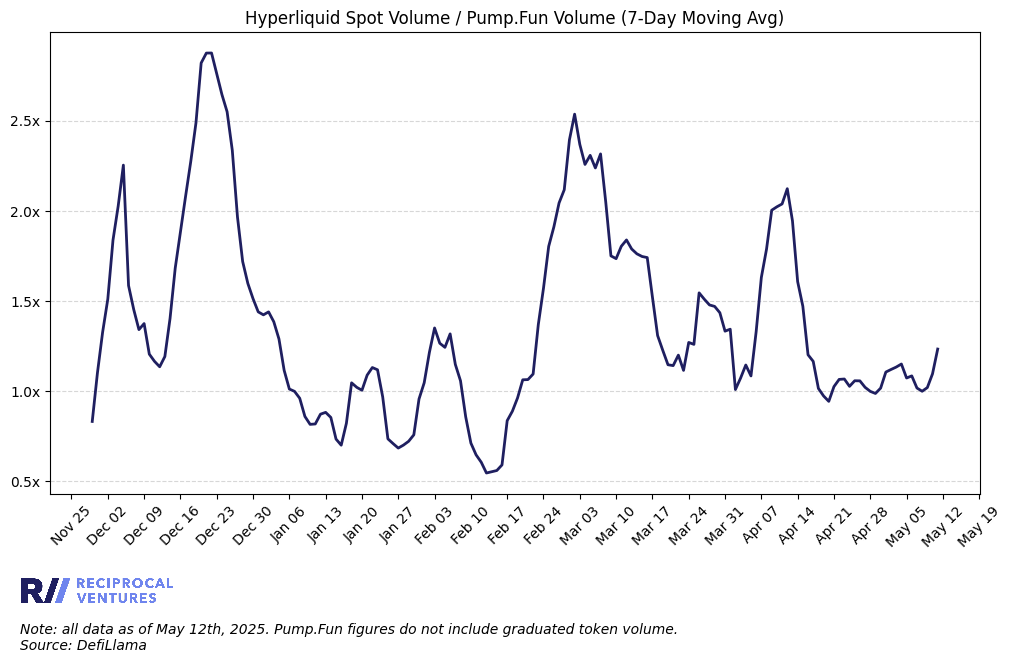

          date  hyperliquid-spot-volume  hyperliquid-spot-volume  \
160 2025-05-02                128977405                128977405   
161 2025-05-03                102347437                102347437   
162 2025-05-04                 87201050                 87201050   
163 2025-05-05                103321597                103321597   
164 2025-05-06                148487227                148487227   
165 2025-05-07                123317603                123317603   
166 2025-05-08                238514707                238514707   
167 2025-05-09                187434250                187434250   
168 2025-05-10                183465847                183465847   
169 2025-05-11                203456685                203456685   

     hyperliquid-memecoin-market-share  hyperliquid-memecoin-market-share-7d  
160                           1.000703                              1.120304  
161                           0.919520                              1.133728  
162           

In [13]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    hyperliquid_spot_volume_data = json.load(f)

hyperliquid_spot_volume_df = pd.DataFrame(hyperliquid_spot_volume_data["totalDataChart"], columns=["timestamp", "hyperliquid-spot-volume"])
hyperliquid_spot_volume_df["date"] = pd.to_datetime(hyperliquid_spot_volume_df["timestamp"], unit="s")
hyperliquid_spot_volume_df = hyperliquid_spot_volume_df[["date", "hyperliquid-spot-volume"]]

# Load Pump.Fun volume data
with open("raw-data/defillama-raw-data/defillama_pumpfun-spot-volumes.json", "r") as f:
    pumpfun_spot_volume_data = json.load(f)

pumpfun_spot_volume_df = pd.DataFrame(pumpfun_spot_volume_data["totalDataChart"], columns=["timestamp", "pumpfun-spot-volume"])
pumpfun_spot_volume_df["date"] = pd.to_datetime(pumpfun_spot_volume_df["timestamp"], unit="s")
pumpfun_spot_volume_df = pumpfun_spot_volume_df[["date", "pumpfun-spot-volume"]]

# Merge datasets
df = pd.merge(hyperliquid_spot_volume_df, pumpfun_spot_volume_df, on="date", how="inner")
df["hyperliquid-memecoin-market-share"] = df["hyperliquid-spot-volume"] / df["pumpfun-spot-volume"]

# Calculate trailing 7-day average
df["hyperliquid-memecoin-market-share-7d"] = df["hyperliquid-memecoin-market-share"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["hyperliquid-memecoin-market-share-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume / Pump.Fun Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Pump.Fun figures do not include graduated token volume.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-to-pumpfun-volume-ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "hyperliquid-spot-volume", "hyperliquid-spot-volume", "hyperliquid-memecoin-market-share", "hyperliquid-memecoin-market-share-7d"]].tail(10))

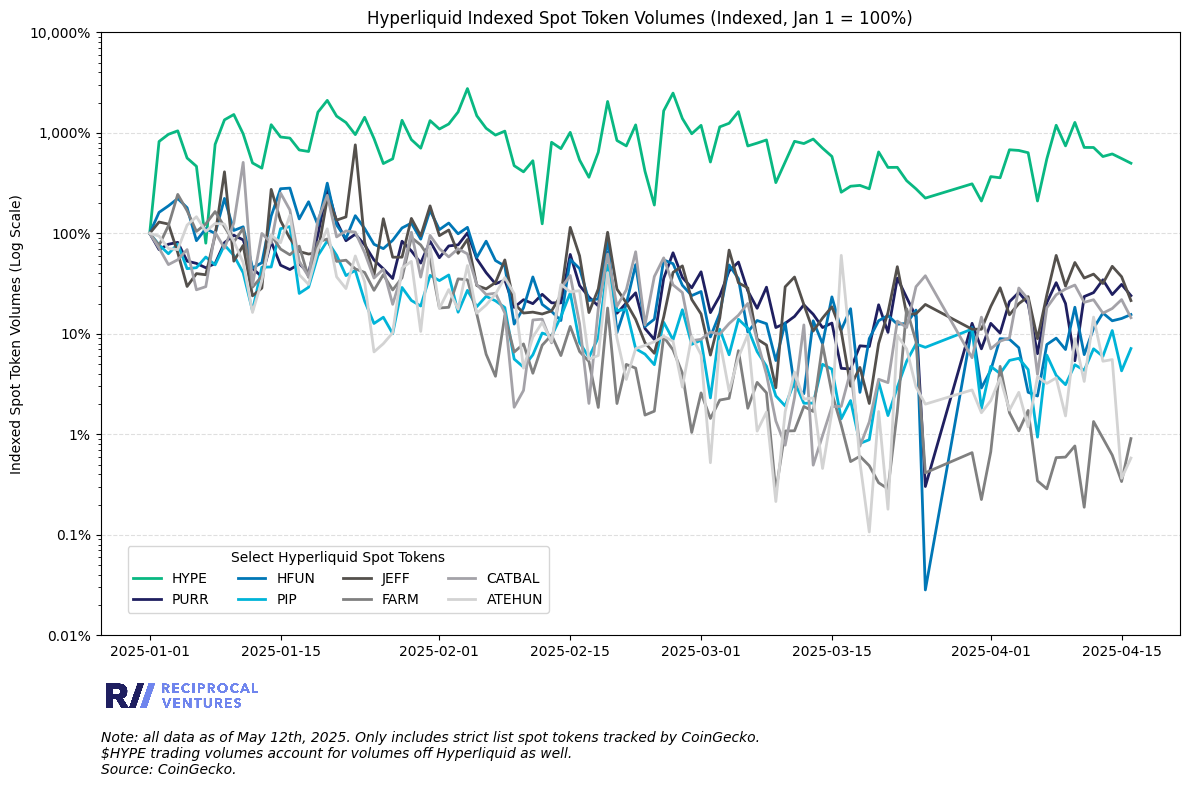

          date         HYPE       PURR       HFUN        PIP       JEFF  \
92  2025-04-07   550.734734  20.451432   7.828174   6.132986  24.394752   
93  2025-04-08  1189.713142  32.285376   9.056562   3.859054  60.261440   
94  2025-04-09   741.433332  20.026953   6.976906   3.117972  29.833857   
95  2025-04-10  1269.900497   5.393681  18.383283   4.922878  51.244331   
96  2025-04-11   715.545516  23.491927   6.211235   4.325685  35.890344   
97  2025-04-12   714.577708  25.695734  11.340230   7.091407  39.269146   
98  2025-04-13   580.886354  34.483476  16.106702   5.966686  31.674685   
99  2025-04-14   616.484813  24.565764  13.480219  10.782913  46.961992   
100 2025-04-15   554.963741  31.019274  14.204097   4.282122  36.997383   
101 2025-04-16   498.405878  23.984125  15.546348   7.136441  21.417044   

         FARM     CATBAL     ATEHUN  
92   0.286605  18.198040   3.209780  
93   0.586293  24.469390   3.637409  
94   0.593421  27.907685   1.523739  
95   0.766109  30.5631

In [14]:
# Load Hyperliquid spot stric list volume data

# Load color palette
color_palette = {
    'Hyperliquid':'#09b882', 'Black':'#000000',
    'Bold Blue':'#1f1f60', 'Sky Blue':'#6f85ee',
    'blue 1':'#03045e', 'blue 2':'#0077b6',
    'blue 3':'#00b4d8', 'blue 4':'#90e0ef',
    'blue 5':'#caf0f8', 'blue 6':'#d9f4fa', 'blue 7': '#f1fcfe',
    'Mid Grey':'#54504c','Other Grey':'#a4a2a8', 'Pure Grey': '#808080','Lighter Grey': '#A9A9A9','Lightest Grey': '#D3D3D3',
}

asset_colors = {
    'HYPE': color_palette['Hyperliquid'],
    'PURR': color_palette['Bold Blue'],
    'HFUN': color_palette['blue 2'],
    'PIP': color_palette['blue 3'],
    'JEFF': color_palette['Mid Grey'],
    'FARM': color_palette['Pure Grey'],
    'CATBAL': color_palette['Other Grey'],
    'ATEHUN': color_palette['Lightest Grey'],
}

# Create asset map
assets = {
    'hyperliquid': 'HYPE',
    "purr-2": "PURR",
    "hypurr-fun": "HFUN",
    "pip-3": "PIP",
    "jeff-3": "JEFF",
    "farm-2": "FARM",
    "catbal": "CATBAL",
    'atehun': 'ATEHUN',
}

df_master = None

for raw_id, asset in assets.items():
    # Load data spot asset data
    path = f"raw-data/coingecko-raw-data/coingecko_{raw_id}_spot_strict_list_data.json"
    with open(path) as f:
        data = json.load(f)

    coin_df = (
        pd.DataFrame(data["total_volumes"], columns=["timestamp", f"{asset}-spot-volume"])
          .assign(date=lambda d: pd.to_datetime(d["timestamp"], unit="ms"))
          .loc[:, ["date", f"{asset}-spot-volume"]]
    )

    # Transform data to 7d avg index
    first_volume = coin_df[f"{asset}-spot-volume"].iloc[0]
    coin_df[f"{asset}-indexed-spot-volume"] = coin_df[f"{asset}-spot-volume"] / first_volume * 100
    coin_df[f"{asset}-indexed-spot-volume-7d"] = coin_df[f"{asset}-indexed-spot-volume"].rolling(7).mean()
    coin_df[f'{asset}-spot-volume-7d'] = coin_df[f'{asset}-spot-volume'].rolling(7).mean()

    # Kill values not getting plotted
    coin_df[f'{asset}'] = coin_df[f"{asset}-indexed-spot-volume"]
    coin_df = coin_df[["date", f"{asset}"]]
    
    # Merge dataframes
    df_master = coin_df if df_master is None else df_master.merge(coin_df, on="date", how="inner")
    df_master = df_master.sort_values("date").reset_index(drop=True)

# Create the line chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the line chart with custom colors
for raw_id, asset in assets.items():
    ax.plot(
        df_master['date'], 
        df_master[asset], 
        label=asset, 
        color=asset_colors[asset],
        linewidth=2
    )

# Setting labels and title
ax.set_title('Hyperliquid Indexed Spot Token Volumes (Indexed, Jan 1 = 100%)')
ax.set_ylabel('Indexed Spot Token Volumes (Log Scale)')

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Apply a percentage formatter to the y-axis
def format_y(x, _):
    """Integers for values ≥ 1, variable decimals for values < 1."""
    if x >= 1:
        return f"{x:,.0f}%" # e.g. 2 000
    # format to 10 dp then strip trailing zeros/decimal point
    return f"{x:.10f}".rstrip("0").rstrip(".")+"%"

ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_y))

# Set y-axis limits with lower bound as 10 (10^1)
ax.set_ylim(0.01, 10000)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Add logo
add_logo(ax, position=(0.075, -0.1))

# Add sources and note
text_box = ax.text(0, -0.23, f"Note: all data as of {date}. Only includes strict list spot tokens tracked by CoinGecko.\n$HYPE trading volumes account for volumes off Hyperliquid as well.\nSource: CoinGecko.",
                   ha='left', transform=ax.transAxes, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0), fontstyle='italic')

# Center the legend below the chart
plt.legend(title='Select Hyperliquid Spot Tokens', bbox_to_anchor=(0.22, 0.16), loc='upper center', ncol=4)

# Ensure the layout adapts to fit all elements (legend, text, etc.)
plt.tight_layout()

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-indexed-spot-token-volumes.png", dpi=300, bbox_inches='tight')

# Show
plt.show()
print(df_master.tail(10))

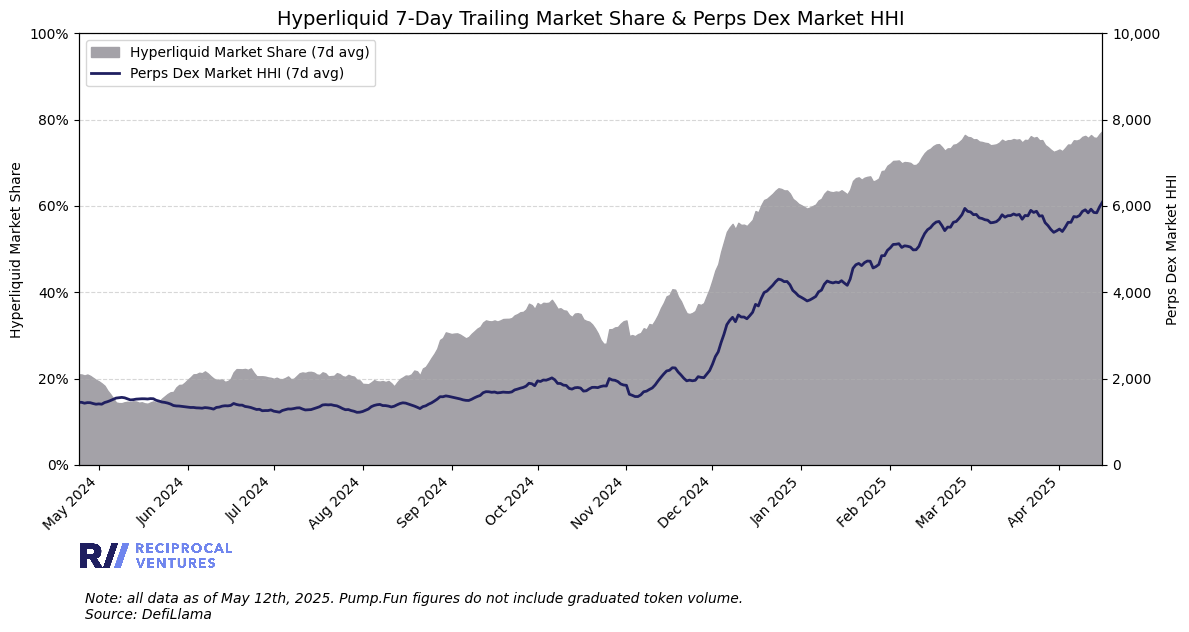

          date  market_share      ms_7d          hhi       hhi_7d
355 2025-04-08     77.228630  75.389841  6038.494594  5779.223736
356 2025-04-09     78.306628  76.026315  6202.778184  5874.672297
357 2025-04-10     77.153257  76.258232  6041.563253  5912.006073
358 2025-04-11     74.727847  75.772607  5668.701714  5841.197767
359 2025-04-12     74.213667  76.443727  5599.281147  5925.286862
360 2025-04-13     71.460748  75.840823  5284.338779  5850.098938
361 2025-04-14     77.447991  75.791253  6065.108823  5842.895213
362 2025-04-15     83.490097  76.685748  7010.341427  5981.730475
363 2025-04-16     83.297362  77.398710  6978.672192  6092.572476
364 2025-04-17      0.000000  66.376816  1568.493632  5453.562530


In [15]:
# FIX LOGO AND GENERAL CLEANUP

# 1) Load & parse CSV
df = pd.read_csv(
    "raw-data/artemis-raw-data/artemis_perps-trading-volume.csv",
    dtype={"Date": str}
)
df["date"] = pd.to_datetime(df["Date"], format="%d-%b-%y")
df.drop(columns=["Date"], inplace=True)

# 2) Compute volumes & drop zero days
dex_cols = [c for c in df.columns if c != "date"]
df[dex_cols] = df[dex_cols].fillna(0)
df["total_volume"] = df[dex_cols].sum(axis=1)
df = df[df["total_volume"] > 0].copy()

# 3) Market share & HHI
df["market_share"] = df["Hyperliquid"] / df["total_volume"] * 100
shares = df[dex_cols].div(df["total_volume"], axis=0) * 100
df["hhi"] = (shares ** 2).sum(axis=1)

# 4) 7‑day trailing averages
df["ms_7d"]  = df["market_share"].rolling(7, min_periods=7).mean()
df["hhi_7d"] = df["hhi"].rolling(7, min_periods=7).mean()

# 5) Drop any rows without a full 7‑day average, plus the very last day
plot_df = df[df["ms_7d"].notna()].iloc[:-1]

# 6) Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Area: Hyperliquid market share
ax1.fill_between(
    plot_df["date"], plot_df["ms_7d"],
    color="#a4a2a8", alpha=1,
    label="Hyperliquid Market Share (7d avg)"
)
ax1.set_ylabel("Hyperliquid Market Share")
ax1.set_ylim(0, 100)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# X‑axis exactly from first valid day → last
ax1.set_xlim(plot_df["date"].iloc[0], plot_df["date"].iloc[-1])
ax1.margins(x=0)                  # no extra padding
fig.subplots_adjust(left=0.07)    # tighten left edge

# Monthly ticks, lighter crowding
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Line: Perps‑DEX HHI
ax2 = ax1.twinx()
ax2.plot(
    plot_df["date"], plot_df["hhi_7d"],
    color="#1f1f60", linewidth=2,
    label="Perps Dex Market HHI (7d avg)"
)
ax2.set_ylabel("Perps Dex Market HHI")
ax2.set_ylim(0, 10_000)
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Title, grid & legend
ax1.set_title("Hyperliquid 7‑Day Trailing Market Share & Perps Dex Market HHI", fontsize=14)
ax1.grid(axis="y", linestyle="--", alpha=0.5)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

# Save & show
add_logo(ax1, position=(0.075, -0.21))
plt.figtext(0.075, -0.04, f"Note: all data as of {date}. Pump.Fun figures do not include graduated token volume.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')
plt.tight_layout()
plt.savefig("plots/hyperliquid_marketshare_hhi_7d.png", dpi=300, bbox_inches="tight")
plt.show()

# Debug print
print(df[["date","market_share","ms_7d","hhi","hhi_7d"]].tail(10))


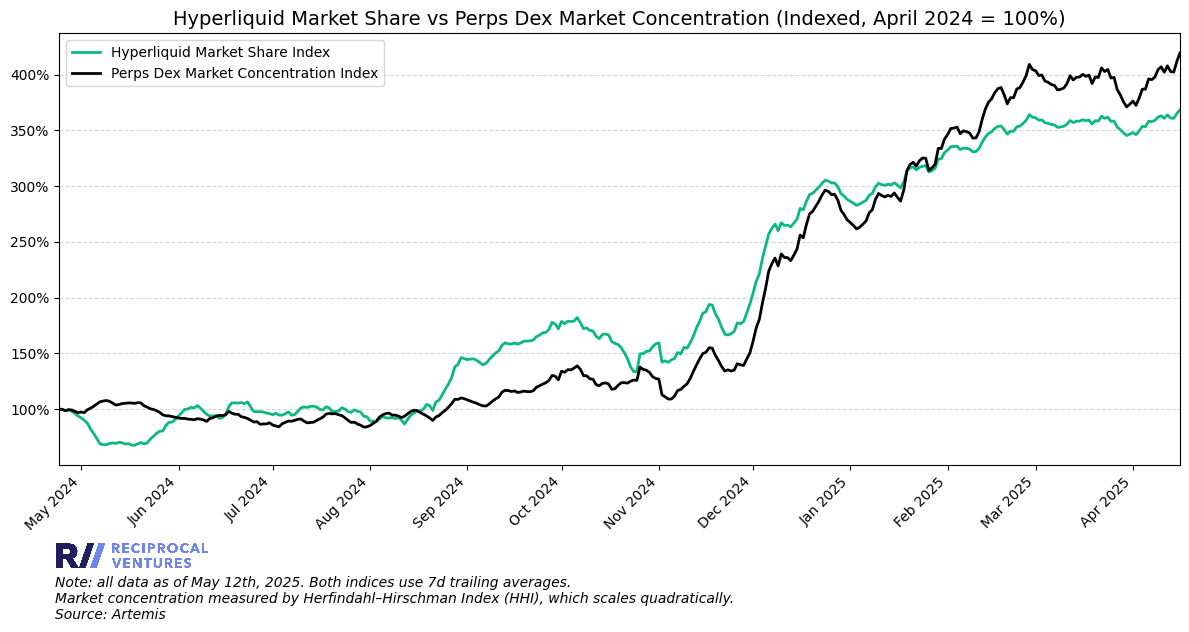

             Aevo         ApeX      Avantis       Bluefin  Drift Protocol  \
354  1.893289e+07  482539864.0  52322850.74  1.116223e+08    2.757601e+08   
355  7.951830e+06  269397687.2  17516227.95  9.135697e+07    1.453212e+08   
356  1.207307e+07  371060293.4  15032929.84  9.772171e+07    2.043770e+08   
357  1.305575e+07  251647161.8  11736928.75  7.751257e+07    9.936844e+07   
358  8.583353e+06  278866855.5   9789503.48  8.117606e+07    1.191645e+08   
359  6.129943e+06  309788923.4  14371987.19  7.382531e+07    1.240203e+08   
360  5.891644e+06  328372885.0  10987507.41  7.671639e+07    1.034122e+08   
361  6.478715e+06  281138678.9  17882976.11  5.093400e+07    1.479805e+08   
362  6.463340e+06  231367729.8  29804181.56  4.318482e+07    1.173241e+08   
363  7.408841e+06  235526389.2  37915755.54  5.206847e+07    1.364144e+08   

         dYdX v3      dYdX v4  Gains Network           GMX  Holdstation  ...  \
354  516435708.4  516435708.4            0.0  5.831641e+08  25258746.27 

In [16]:
import sys
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator
import matplotlib.ticker as mtick

# 0) logo util
sys.path.append("utils")
from logo import add_logo

# 1) Load & parse CSV
df = pd.read_csv(
    "raw-data/artemis-raw-data/artemis_perps-trading-volume.csv",
    dtype={"Date": str}
)
df["date"] = pd.to_datetime(df["Date"], format="%d-%b-%y")
df.drop(columns=["Date"], inplace=True)

# 2) Compute volumes & drop zero‑volume days
dex_cols = [c for c in df.columns if c != "date"]
df[dex_cols] = df[dex_cols].fillna(0)
df["total_volume"] = df[dex_cols].sum(axis=1)
df = df[df["total_volume"] > 0].copy()

# 3) Market share & HHI
df["market_share"] = df["Hyperliquid"] / df["total_volume"] * 100
shares = df[dex_cols].div(df["total_volume"], axis=0) * 100
df["hhi"] = (shares ** 2).sum(axis=1)

# 4) 7‑day trailing averages
df["ms_7d"]  = df["market_share"].rolling(7, min_periods=7).mean()
df["hhi_7d"] = df["hhi"].rolling(7, min_periods=7).mean()

# 5) Prepare plot DataFrame (drop initial NaNs & last incomplete day)
plot_df = df[df["ms_7d"].notna()].iloc[:-1].copy()

# 6) Build index series (100 at first date)
idx_df = plot_df.copy()
idx_df["ms_index"]  = idx_df["ms_7d"]  / idx_df["ms_7d"].iloc[0]  * 100
idx_df["hhi_index"] = idx_df["hhi_7d"] / idx_df["hhi_7d"].iloc[0] * 100

# 7) Plot indexed growth
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    idx_df["date"], idx_df["ms_index"], color='#09b882',
    linewidth=2, label="Hyperliquid Market Share Index"
)
ax.plot(
    idx_df["date"], idx_df["hhi_index"], color='black',
    linewidth=2, label="Perps Dex Market Concentration Index"
)

# 8) Styling
ax.set_title("Hyperliquid Market Share vs Perps Dex Market Concentration (Indexed, April 2024 = 100%)", fontsize=14)
ax.set_xlim(idx_df["date"].iloc[0], idx_df["date"].iloc[-1])

# format x‑axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# format y‑axis as percentage of the base 100
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.margins(x=0)
fig.subplots_adjust(left=0.07)
ax.legend(loc="upper left")

# 9) Logo & footnote
add_logo(ax, position=(0.065, -0.21))
plt.figtext(
    0.05, -0.04,
    f"Note: all data as of {date}. Both indices use 7d trailing averages.\nMarket concentration measured by Herfindahl–Hirschman Index (HHI), which scales quadratically.\nSource: Artemis",
    ha='left', fontsize=10, style='italic'
)

# 10) Save & show
plt.tight_layout()
plt.savefig("plots/hyperliquid_HHI_indexed_growth.png", dpi=300, bbox_inches="tight")
plt.show()

print(idx_df.tail(10))

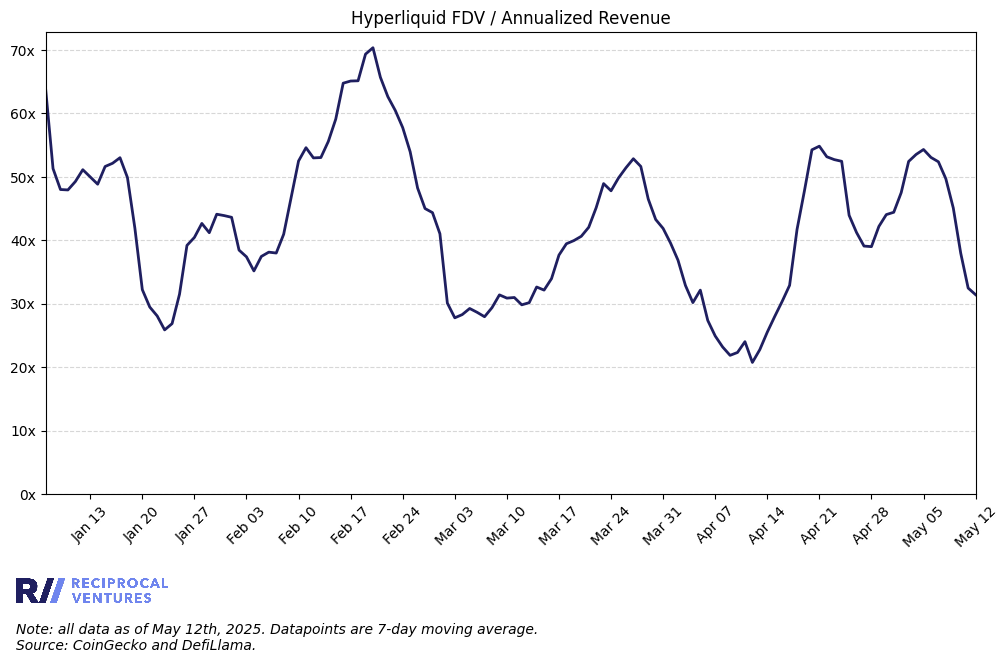

          date     fees  annualized-fees      price           fdv  \
121 2025-05-03   597229        217988585  20.765488  2.076549e+10   
122 2025-05-04   817513        298392245  21.053278  2.105328e+10   
123 2025-05-05  1464695        534613675  19.821263  1.982126e+10   
124 2025-05-06  1492495        544760675  20.291207  2.029121e+10   
125 2025-05-07  1767519        645144435  20.993991  2.099399e+10   
126 2025-05-08  2649191        966954715  21.041196  2.104120e+10   
127 2025-05-09  3015825       1100776125  23.232083  2.323208e+10   
128 2025-05-10  1491492        544394580  24.732218  2.473222e+10   
129 2025-05-11  2233125        815090625  26.094998  2.609500e+10   
130 2025-05-12  2289695        835738675  24.873025  2.487303e+10   

     hype-fdv-rev-multiple  hype-fdv-rev-multiple-7d  
121              95.259520                 52.409119  
122              70.555713                 53.507653  
123              37.075861                 54.291392  
124              37.

In [38]:
# total supply for FDV
total_hype_tokens = 1000000000

# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp_s", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp_s"], unit="s").dt.normalize()
fee_df = fee_df[["date", "fees"]]
fee_df['annualized-fees'] = fee_df['fees'] * 365

# Load Hyperliquid close price data
with open("raw-data/coingecko-raw-data/coingecko_hyperliquid_spot_strict_list_data.json", "r") as f:
    price_data = json.load(f)

price_df = pd.DataFrame(price_data["prices"], columns=["timestamp_ms", "price"])
price_df["date"] = pd.to_datetime(price_df["timestamp_ms"], unit="ms").dt.normalize()  # use price_df, unit=ms
price_df = price_df[["date", "price"]]
price_df["fdv"] = price_df["price"] * total_hype_tokens

# Merge Hyperliquid datasets
df = pd.merge(fee_df, price_df, on="date", how="inner")

df["hype-fdv-rev-multiple"] = df["fdv"] / df["annualized-fees"]

# Calculate trailing 7-day average
df["hype-fdv-rev-multiple-7d"] = df["hype-fdv-rev-multiple"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["hype-fdv-rev-multiple-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
ax.margins(x=0)
ax.set_ylim(bottom=0)

# Y-axis formatting
ax.set_title("Hyperliquid FDV / Annualized Revenue")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Datapoints are 7-day moving average. \nSource: CoinGecko and DefiLlama.", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid_fdv_to_annualized-revenue_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

print(df.tail(10))

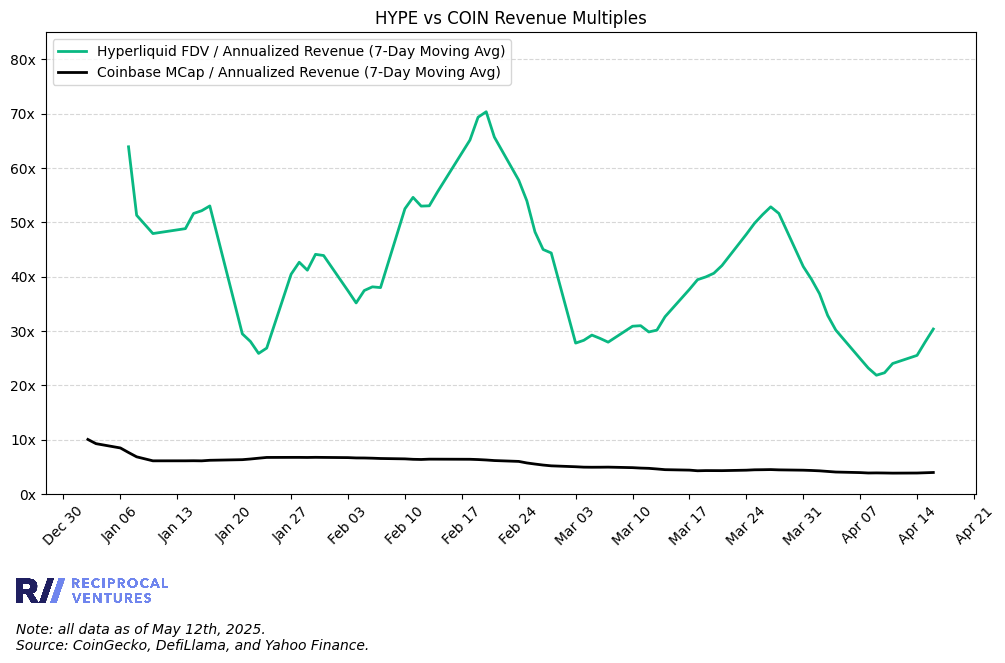

         date     fees  annualized-fees      price           fdv  \
61 2025-04-03  1715095        626009675  11.831829  1.183183e+10   
62 2025-04-04  1815068        662499820  11.716571  1.171657e+10   
63 2025-04-07  3117000       1137705000  10.266673  1.026667e+10   
64 2025-04-08  1746313        637404245  11.490222  1.149022e+10   
65 2025-04-09  2837027       1035514855  11.202466  1.120247e+10   
66 2025-04-10  1686123        615434895  13.580674  1.358067e+10   
67 2025-04-11  1327396        484499540  14.341905  1.434190e+10   
68 2025-04-14  1491560        544419400  15.362708  1.536271e+10   
69 2025-04-15  1221402        445811730  15.759650  1.575965e+10   
70 2025-04-16  1508963        550771495  15.109160  1.510916e+10   

    hype-fdv-rev-multiple  hype-fdv-rev-multiple-7d  coin_market_cap  \
61              18.900394                 32.867089     3.588607e+10   
62              17.685395                 30.163088     3.374039e+10   
63               9.024020          

In [18]:
# total supply for FDV
total_hype_tokens = 1000000000

# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp_s", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp_s"], unit="s")
fee_df = fee_df[["date", "fees"]]
fee_df['annualized-fees'] = fee_df['fees'] * 365

# Load Hyperliquid close price data
with open("raw-data/coingecko-raw-data/coingecko_hyperliquid_spot_strict_list_data.json", "r") as f:
    price_data = json.load(f)

price_df = pd.DataFrame(price_data["prices"], columns=["timestamp_ms", "price"])
price_df["date"] = pd.to_datetime(price_df["timestamp_ms"], unit="ms")  # use price_df, unit=ms
price_df = price_df[["date", "price"]]
price_df["fdv"] = price_df["price"] * total_hype_tokens

# Merge Hyperliquid datasets
df = pd.merge(fee_df, price_df, on="date", how="inner")
df["hype-fdv-rev-multiple"] = df["fdv"] / df["annualized-fees"]

# Calculate trailing 7-day average
df["hype-fdv-rev-multiple-7d"] = df["hype-fdv-rev-multiple"].rolling(window=7).mean()

# Load Coinbase close price data
with open("raw-data/yahoofinance-raw-data/COIN_mcap_to_annualized_rev.json", "r") as f:
    mcap_data = json.load(f)
mcap_df = pd.DataFrame.from_dict(mcap_data, orient="index")
mcap_df.index.name = "date"
mcap_df.reset_index(inplace=True)
mcap_df["date"] = pd.to_datetime(mcap_df["date"])

df = pd.merge(df, mcap_df, on="date", how="inner")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    df["date"], df["hype-fdv-rev-multiple-7d"], color='#09b882',
    linewidth=2, label="Hyperliquid FDV / Annualized Revenue (7-Day Moving Avg)"
)
ax.plot(
    df["date"], df["coin_7d_avg"], color='black',
    linewidth=2, label="Coinbase MCap / Annualized Revenue (7-Day Moving Avg)"
)


# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("HYPE vs COIN Revenue Multiples")
ax.set_ylim(0, 85)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
ax.legend(loc="upper left")
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: CoinGecko, DefiLlama, and Yahoo Finance.", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid_vs_coinbase_multiples_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

print(df.tail(10))

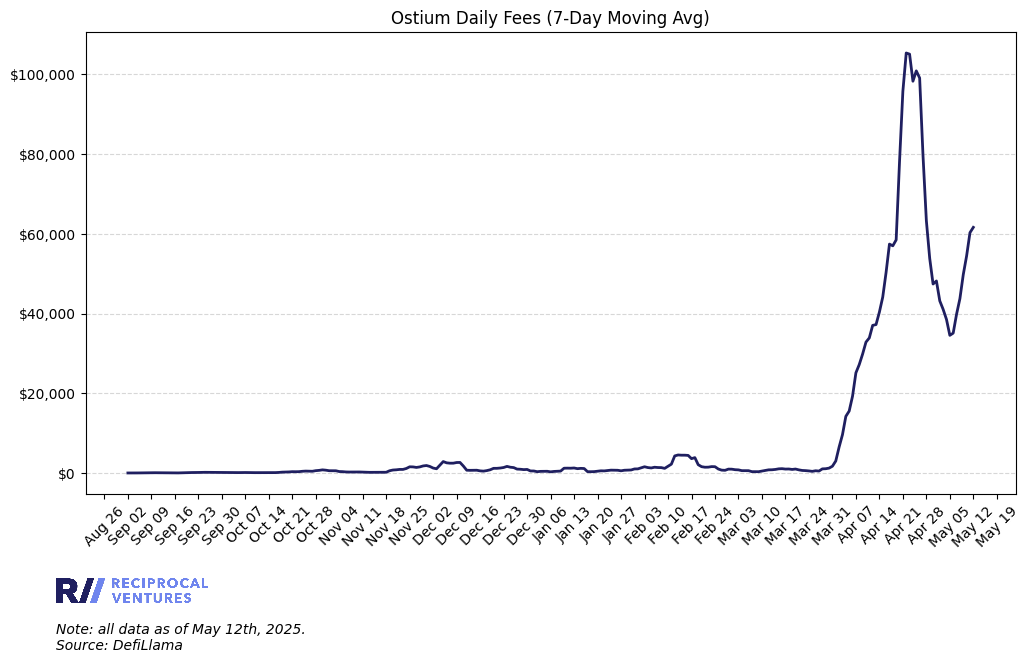

          date  ostium-fees  ostium-fees-7d
249 2025-05-03        14629    41060.571429
250 2025-05-04        11980    38528.857143
251 2025-05-05        47822    34532.285714
252 2025-05-06        55676    35093.428571
253 2025-05-07        74057    39818.285714
254 2025-05-08        78072    43732.428571
255 2025-05-09        66062    49756.857143
256 2025-05-10        47556    54460.714286
257 2025-05-11        52766    60287.285714
258 2025-05-12        57149    61619.714286


In [19]:
# Load Ostium fees data
with open("raw-data/defillama-raw-data/defillama_ostium-fees.json", "r") as f:
    fee_data = json.load(f)

df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "ostium-fees"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df = df[["date", "ostium-fees"]]

# Calculate trailing 7-day average
df["ostium-fees-7d"] = df["ostium-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["ostium-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_title("Ostium Daily Fees (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/ostium_fees_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))

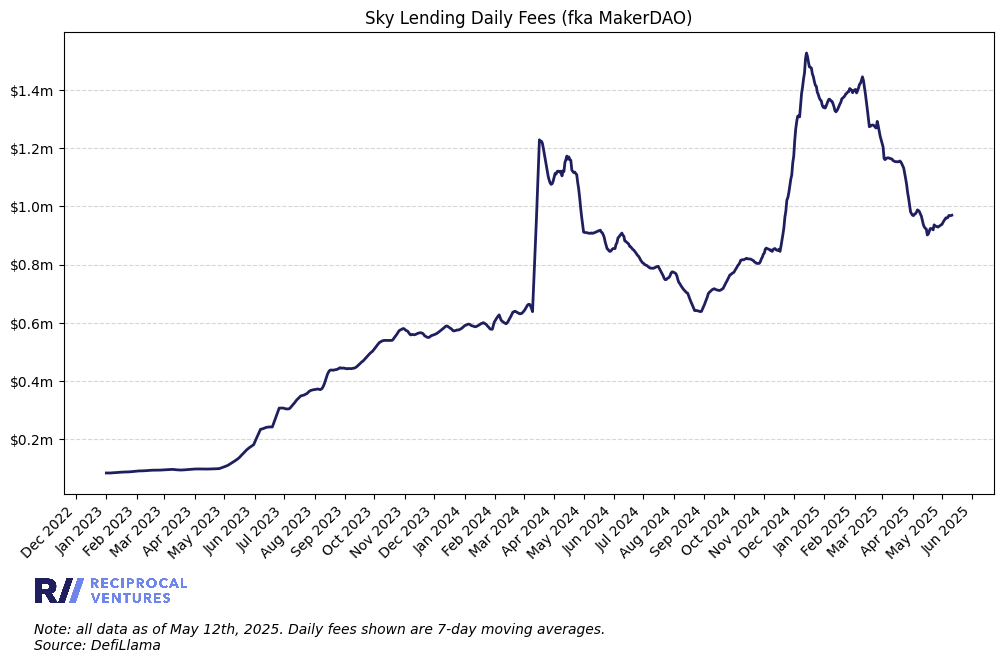

           date  makerdao-fees  makerdao-fees-7d
1991 2025-05-02         984770     945036.285714
1992 2025-05-03         977224     950750.285714
1993 2025-05-04         971693     955557.857143
1994 2025-05-05         977453     960683.428571
1995 2025-05-06         936245     960234.142857
1996 2025-05-07         949734     961974.142857
1997 2025-05-08         985421     968934.285714
1998 2025-05-09         979760     968218.571429
1999 2025-05-10         979122     968489.714286
2000 2025-05-11         980037     969681.714286


In [20]:
# Load MakerDAO fees data
with open("raw-data/defillama-raw-data/defillama_makerdao-fees.json", "r") as f:
    fee_data = json.load(f)

df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "makerdao-fees"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df = df[["date", "makerdao-fees"]]

# Calculate trailing 7-day average
df["makerdao-fees-7d"] = df["makerdao-fees"].rolling(window=7).mean()

# Filter the data for a given time period
df = df[df['date'] >= '2023-01-01']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["makerdao-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# Y-axis formatting
ax.set_title("Sky Lending Daily Fees (fka MakerDAO)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000:,.1f}m'))

# format x‑axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Daily fees shown are 7-day moving averages.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/makerdao_fees_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))

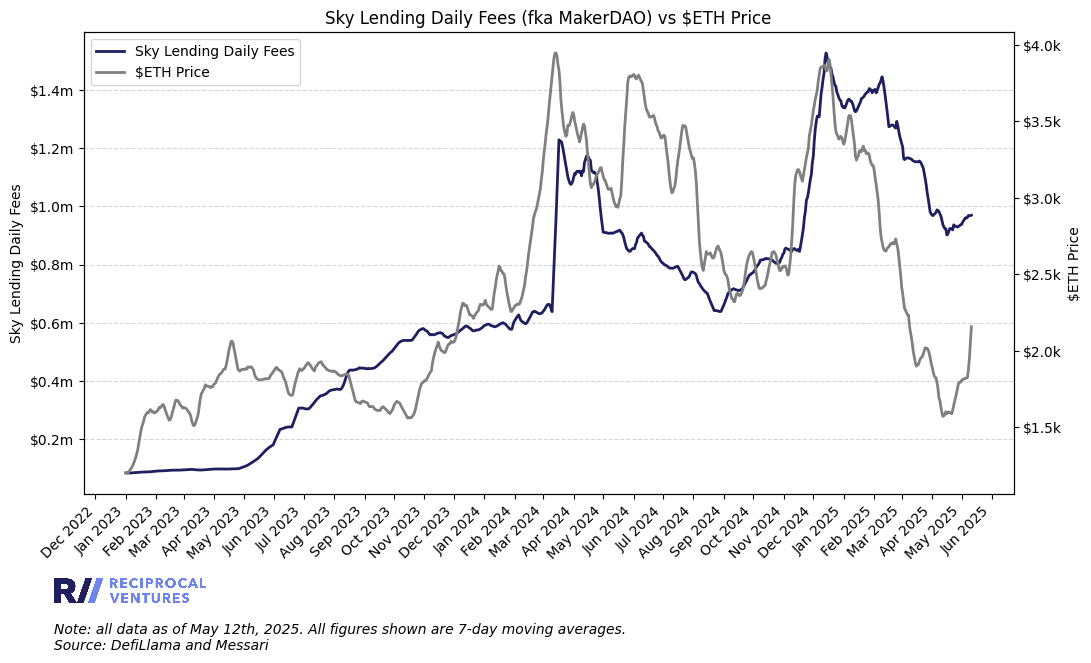

           date  makerdao-fees  makerdao-fees-7d        close  eth-close-7d
1582 2025-05-02         984770     945036.285714  1842.897320   1812.645606
1583 2025-05-03         977224     950750.285714  1834.517357   1814.538059
1584 2025-05-04         971693     955557.857143  1811.758413   1817.405106
1585 2025-05-05         977453     960683.428571  1820.214004   1820.288644
1586 2025-05-06         936245     960234.142857  1816.421298   1822.856978
1587 2025-05-07         949734     961974.142857  1811.636737   1825.394420
1588 2025-05-08         985421     968934.285714  2207.072422   1877.788222
1589 2025-05-09         979760     968218.571429  2345.216139   1949.548053
1590 2025-05-10         979122     968489.714286  2583.578924   2056.556848
1591 2025-05-11         980037     969681.714286  2513.934166   2156.867670


In [21]:
# Load MakerDAO fees data
with open("raw-data/defillama-raw-data/defillama_makerdao-fees.json", "r") as f:
    maker_data = json.load(f)

maker_df = pd.DataFrame(maker_data["totalDataChart"], columns=["timestamp", "makerdao-fees"])
maker_df["date"] = pd.to_datetime(maker_df["timestamp"], unit="s")
maker_df = maker_df[["date", "makerdao-fees"]]

# Calculate trailing 7-day average
maker_df["makerdao-fees-7d"] = maker_df["makerdao-fees"].rolling(window=7).mean()


# Load Ethereium price data
with open('raw-data/messari-raw-data/messari_ethereum_price.json', 'r') as f:
    eth_data = json.load(f)

points = eth_data['data']['points']
eth_df = pd.DataFrame(points, columns=[
    'timestamp',
    'open',
    'high',
    'low',
    'close',
    'volume'
])
eth_df["date"] = pd.to_datetime(eth_df["timestamp"], unit="s")
eth_df = eth_df[['date','close']]

# Calculate trailing 7-day average
eth_df['eth-close-7d'] = eth_df['close'].rolling(window=7).mean()

# Merge datasets
df = pd.merge(maker_df, eth_df, on="date", how="inner")

# Filter the data for a given time period
df = df[df['date'] >= '2023-01-01']

# Begin charting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MakerDAO data
ax1.plot(df["date"], df["makerdao-fees-7d"], color="#1f1f60", linewidth=2, label="Sky Lending Daily Fees")
ax1.set_ylabel("Sky Lending Daily Fees")
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000:,.1f}m'))

# format x‑axis
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Plot $ETH data
ax2 = ax1.twinx()
ax2.plot(df["date"], df["eth-close-7d"], color="grey", linewidth=2, label="$ETH Price")
ax2.set_ylabel('$ETH Price')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000:,.1f}k'))

# Clean up formatting
ax1.set_title("Sky Lending Daily Fees (fka MakerDAO) vs $ETH Price")
ax1.grid(axis='y', linestyle='--', alpha=0.5)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")
add_logo(ax1, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. All figures shown are 7-day moving averages.\nSource: DefiLlama and Messari", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/makerdao_fees_vs_eth_price.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))

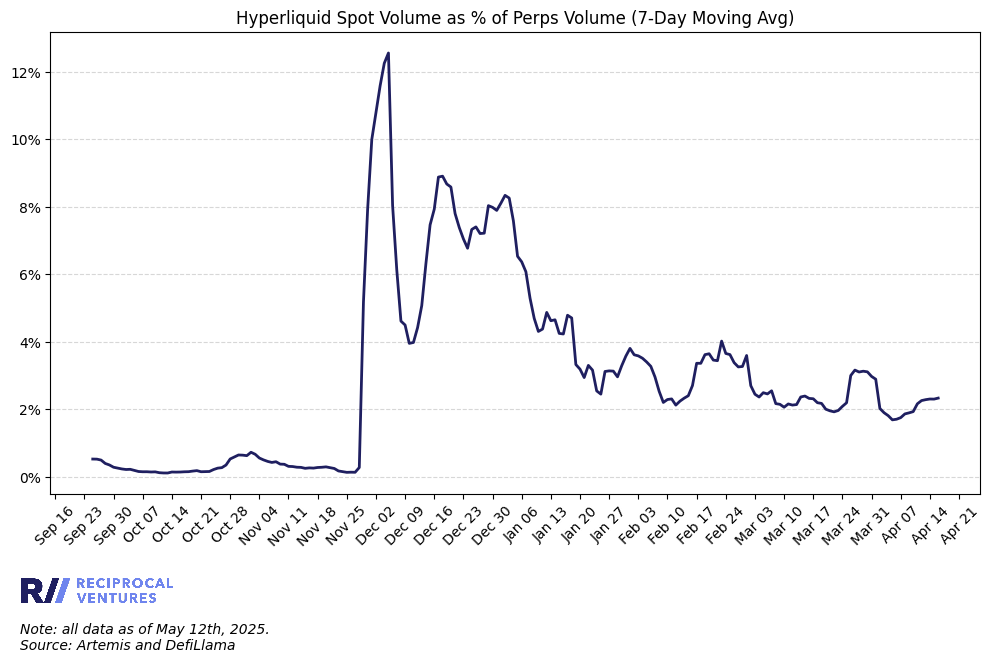

          date  spot-volume  perps-volume  spot-volume-percent-perps-volume  \
201 2025-04-08    163870707  7.827351e+09                          2.093565   
202 2025-04-09    256513559  1.270113e+10                          2.019611   
203 2025-04-10    165359677  7.394696e+09                          2.236193   
204 2025-04-11    187070232  5.731433e+09                          3.263935   
205 2025-04-12    121367900  5.070751e+09                          2.393490   
206 2025-04-13    134246965  6.333385e+09                          2.119671   
207 2025-04-14    126974634  6.316587e+09                          2.010178   
208 2025-04-15    120978471  5.825376e+09                          2.076750   
209 2025-04-16    155624952  6.982591e+09                          2.228756   
210 2025-04-17    171271416           NaN                               NaN   

     spot-volume-percent-perps-volume-7d  
201                             1.864049  
202                             1.895101  
2

In [22]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    spot_volume_data = json.load(f)

spot_volume_df = pd.DataFrame(spot_volume_data["totalDataChart"], columns=["timestamp", "spot-volume"])
spot_volume_df["date"] = pd.to_datetime(spot_volume_df["timestamp"], unit="s")
spot_volume_df = spot_volume_df[["date", "spot-volume"]]

# Load Hyperliquid perps volume data
perps_volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
perps_volume_df['Date'] = pd.to_datetime(perps_volume_df['Date'], format='%d-%b-%y')
perps_volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(perps_volume_df, spot_volume_df, on="date", how="inner")
df["spot-volume-percent-perps-volume"] = df["spot-volume"] / df["perps-volume"] * 100 # convert to %

# Calculate trailing 7-day average
df["spot-volume-percent-perps-volume-7d"] = df["spot-volume-percent-perps-volume"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["spot-volume-percent-perps-volume-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume as % of Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/spot-volume-percent-perps-volume_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "spot-volume", "perps-volume", "spot-volume-percent-perps-volume", "spot-volume-percent-perps-volume-7d"]].tail(10))


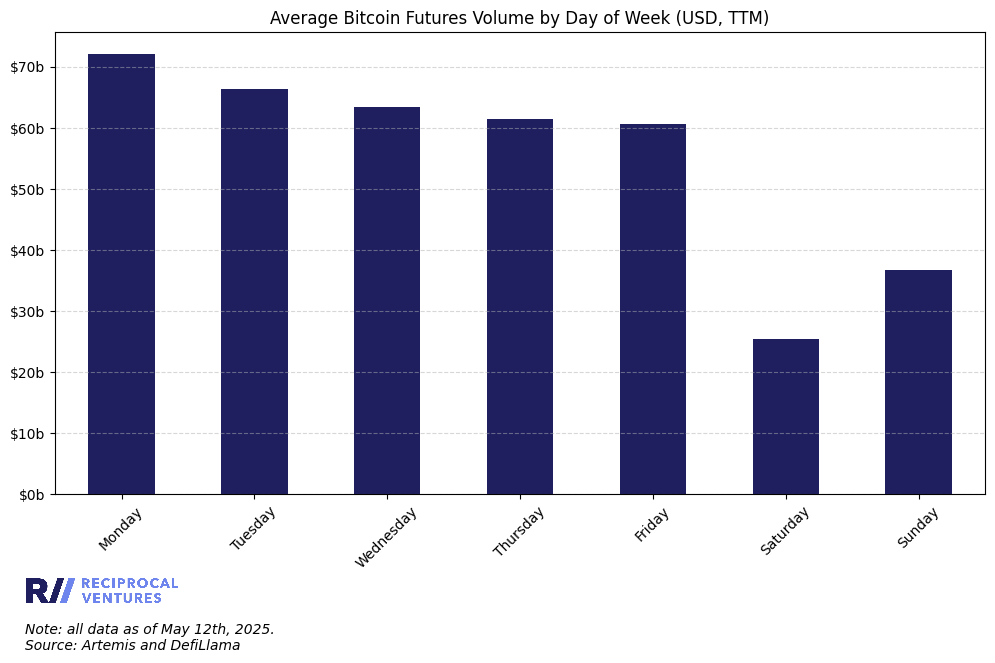

      timestamp  trade_count    volume_usd    volume_btc  volume_other  \
356  1744675200      9657446  5.302851e+10  2.624584e+10  2.678267e+10   
357  1744761600     10240392  5.703359e+10  2.829677e+10  2.873682e+10   
358  1744848000      7154562  4.058176e+10  2.053338e+10  2.004838e+10   
359  1744934400      2844152  1.556197e+10  7.776613e+09  7.785354e+09   
360  1745020800      3584468  2.208868e+10  1.114294e+10  1.094574e+10   
361  1745107200      4089698  2.270491e+10  1.132268e+10  1.138224e+10   
362  1745193600     11988025  7.408143e+10  3.779163e+10  3.628981e+10   
363  1745280000     14517137  9.321374e+10  4.890543e+10  4.430831e+10   
364  1745366400     11829748  7.174540e+10  3.569404e+10  3.605136e+10   
365  1745452800      8450446  5.054991e+10  2.558029e+10  2.496962e+10   

          date day_of_week  
356 2025-04-15     Tuesday  
357 2025-04-16   Wednesday  
358 2025-04-17    Thursday  
359 2025-04-18      Friday  
360 2025-04-19    Saturday  
361 2025-04

In [23]:
# Load the JSON data
with open('raw-data/messari-raw-data/messari_bitcoin_futures-volume.json', 'r') as f:
    raw = json.load(f)

# Build a DataFrame; adjust column names if yours differ
points = raw['data']['points']
df = pd.DataFrame(points, columns=[
    'timestamp',
    'trade_count',
    'volume_usd',
    'volume_btc',
    'volume_other'
])

# Convert the UNIX timestamp to datetime and extract weekday names
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['day_of_week'] = df['date'].dt.day_name()

# Compute the average USD volume for each day of the week
avg_volume = df.groupby('day_of_week')['volume_usd'].mean()

# Reorder the index so days run from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_volume = avg_volume.reindex(weekday_order)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
avg_volume.plot(kind='bar', ax=ax, color="#1f1f60", xlabel='')

# X-axis formatting
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Average Bitcoin Futures Volume by Day of Week (USD, TTM)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000000:.0f}b'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/bitcoin-futures-by-day-of-week.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))


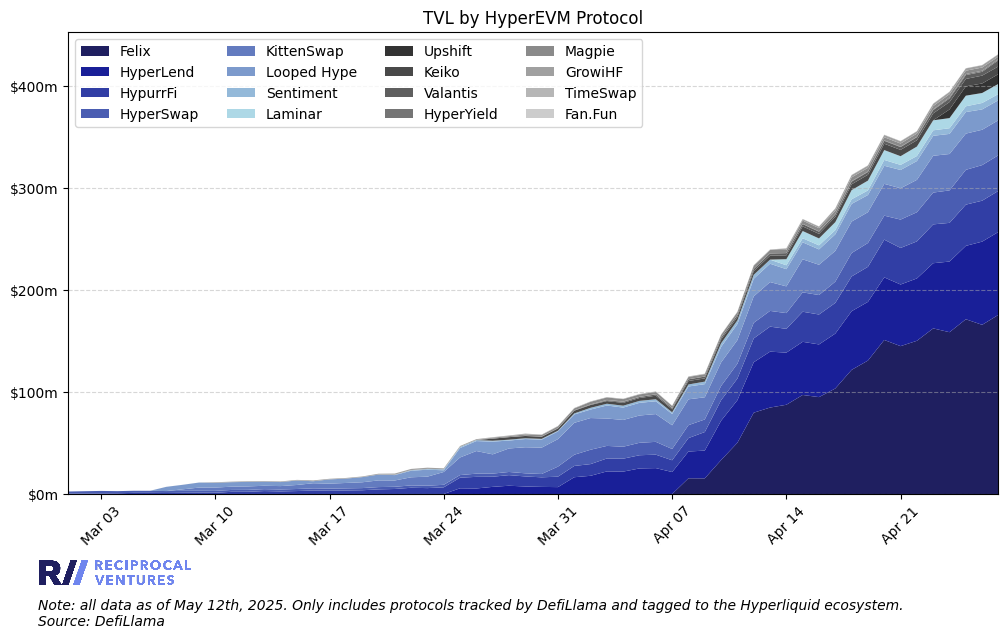

         date         Felix     HyperLend      HypurrFi     HyperSwap  \
53 2025-04-18  1.218474e+08  5.760856e+07  3.409317e+07  2.297480e+07   
54 2025-04-19  1.309845e+08  5.759996e+07  3.442627e+07  2.338966e+07   
55 2025-04-20  1.511938e+08  6.144005e+07  3.703925e+07  2.353479e+07   
56 2025-04-21  1.451423e+08  6.049572e+07  3.589167e+07  2.783859e+07   
57 2025-04-22  1.503920e+08  6.120473e+07  3.635346e+07  2.862491e+07   
58 2025-04-23  1.625549e+08  6.398070e+07  3.813204e+07  3.121266e+07   
59 2025-04-24  1.588172e+08  6.935390e+07  3.797307e+07  3.187275e+07   
60 2025-04-25  1.715278e+08  7.203348e+07  4.047113e+07  3.416021e+07   
61 2025-04-26  1.660598e+08  8.168020e+07  4.017040e+07  3.493229e+07   
62 2025-04-27  1.758924e+08  8.137091e+07  4.031704e+07  3.498771e+07   

      KittenSwap   Looped Hype     Sentiment       Laminar       Upshift  \
53  3.090337e+07  1.732842e+07  4.526640e+06  9.007740e+06  0.000000e+00   
54  3.022498e+07  1.687226e+07  4.488724e+06

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt


# define top HyperEVM protocols tracked by DefiLlama (MAKE SURE THIS IS THE SAME LIST USED WHEN PULLING THE RAW DATA)
hyperevm = {
    'felix': "Felix",
    'hyperlend': 'HyperLend',
    'hypurrfi': 'HypurrFi',
    'hyperswap': 'HyperSwap',
    'kittenswap-finance': 'KittenSwap',
    'looped-hype': 'Looped Hype',
    'sentiment': 'Sentiment',
    'laminar': 'Laminar',
    'upshift': 'Upshift',
    'keiko-finance': 'Keiko',
    'valantis': 'Valantis',
    'hyperyield': 'HyperYield',
    'magpie-ecosystem': 'Magpie',
    'growihf': 'GrowiHF',
    'timeswap': 'TimeSwap',
    'fan.fun': 'Fan.Fun'
}

asset_colors = {
    'Felix':      '#1f1f60',
    'HyperLend':  '#191F98',
    'HypurrFi':   '#313EA5',
    'HyperSwap':  '#4A5DB2',
    'KittenSwap': '#637BBF',
    'Looped Hype':'#7C9ACC',
    'Sentiment':  '#94B9D9',
    'Laminar':    '#ADD8E6',
    'Upshift':    '#333333',
    'Keiko':      '#494949',
    'Valantis':   '#5F5F5F',
    'HyperYield': '#757575',
    'Magpie':     '#8A8A8A',
    'GrowiHF':    '#A0A0A0',
    'TimeSwap':   '#B6B6B6',
    'Fan.Fun':    '#CCCCCC'
}

df_master = None

for raw_id, asset in hyperevm.items():
    with open(f'raw-data/defillama-raw-data/hyperevm/defillama_{raw_id}_tvl.json') as f:
        data = json.load(f)
    
    # Select only the two real keys, then rename
    try:
        try:
            raw_df = pd.DataFrame(
                data['chainTvls']['Hyperliquid']['tvl'],
                columns=['date', 'totalLiquidityUSD']
            )
            raw_df.rename(columns={
                'date': 'timestamp',
                'totalLiquidityUSD': asset
            }, inplace=True)
            raw_df['date'] = pd.to_datetime(raw_df['timestamp'], unit='s')
            raw_df = raw_df[['date', asset]]
        except:
            raw_df = pd.DataFrame(
                data['chainTvls']['Hyperliquid L1-borrowed']['tvl'],
                columns=['date', 'totalLiquidityUSD']
            )
            raw_df.rename(columns={
                'date': 'timestamp',
                'totalLiquidityUSD': asset
            }, inplace=True)
            raw_df['date'] = pd.to_datetime(raw_df['timestamp'], unit='s')
            raw_df = raw_df[['date', asset]]
    except:
        raw_df = pd.DataFrame(
                data['chainTvls']['Hyperliquid L1']['tvl'],
                columns=['date', 'totalLiquidityUSD']
            )
        raw_df.rename(columns={
                'date': 'timestamp',
                'totalLiquidityUSD': asset
            }, inplace=True)
        raw_df['date'] = pd.to_datetime(raw_df['timestamp'], unit='s')
        raw_df = raw_df[['date', asset]]

    # Merge dataframes
    df_master = raw_df if df_master is None else df_master.merge(raw_df, on='date', how='outer')
    df_master.fillna(0, inplace=True)
    
# Filter by appropriate dates
df_master = df_master[df_master['date'] >= '2025-03-01']
df_master = df_master[df_master['date'] <= '2025-04-27']

# Make an ordered list of asset names
asset_list = list(hyperevm.values())

# Sort your master dataframe by date
df_master = df_master.sort_values('date')

# Prepare the values and colors in the right order
dates   = df_master['date']
series  = [df_master[asset] for asset in asset_list]
colors  = [asset_colors[asset]   for asset in asset_list]

# Plot a single stacked‐area call
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(
    dates,
    *series,
    labels=asset_list,
    colors=colors
)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000:.0f}m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

ax.legend(loc='upper left', bbox_to_anchor=(0,1), ncol=4)
plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.17))
ax.margins(x=0)
plt.figtext(0.1, -0.11, f"Note: all data as of {date}. Only includes protocols tracked by DefiLlama and tagged to the Hyperliquid ecosystem.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')
ax.set_title('TVL by HyperEVM Protocol')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperevm-tvl.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset
print(df_master.tail(10))

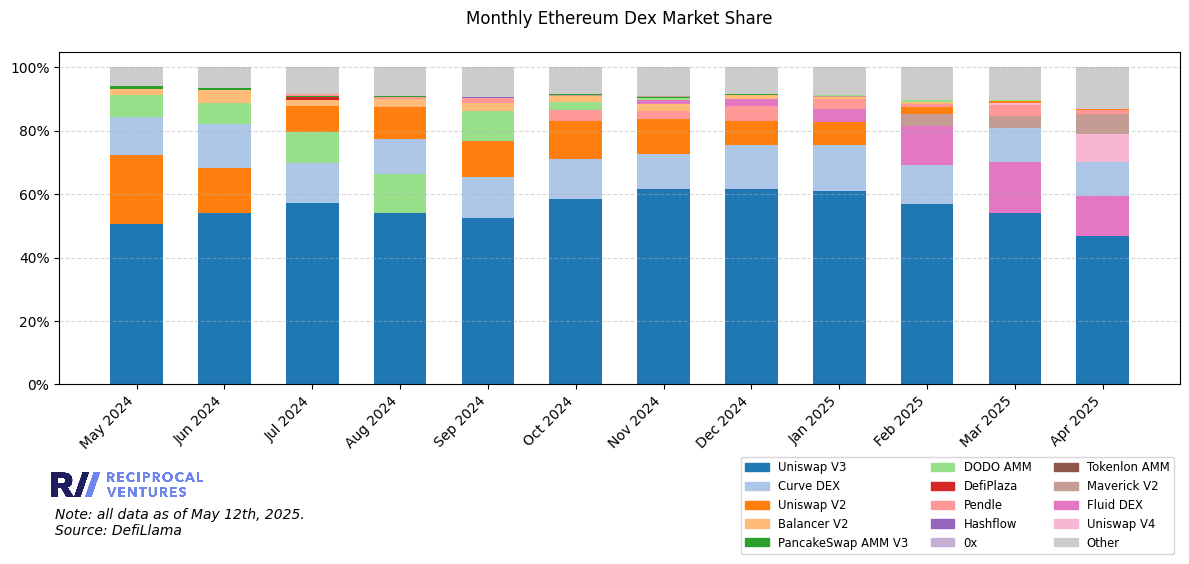

In [25]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import os

# ——— Load the raw JSON breakdown data ———
with open('raw-data/defillama-raw-data/defillama_all-ethereum-dexs.json') as f:
    data = json.load(f)

breakdown = data['totalDataChartBreakdown']

# ——— Build a full daily DataFrame ———
rows = []
for ts, day_vol in breakdown:
    row = {'date': pd.to_datetime(ts, unit='s')}
    row.update(day_vol)
    rows.append(row)

df = pd.DataFrame(rows).fillna(0)

# ——— Filter to your date range ———
df = df[(df['date'] >= '2024-05-01') & (df['date'] <= '2025-04-29')]

# ——— Sort & set date as index ———
df = df.sort_values('date').set_index('date')

# ——— Roll each day into Top 5 + Other ———
daily_agg = []
for dt, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    top5 = sorted_row.iloc[:5]
    other = sorted_row.iloc[5:].sum()
    entry = top5.to_dict()
    entry['Other'] = other
    daily_agg.append(pd.Series(entry, name=dt))

df_top5 = pd.DataFrame(daily_agg).fillna(0)

# ——— Ensure “Other” is the last column ———
all_protocols = [c for c in df_top5.columns if c != 'Other'] + ['Other']
df_top5 = df_top5[all_protocols]

# ——— Aggregate to calendar-month sums (month-end) ———
df_monthly = df_top5.resample('ME').sum()

# ——— If it's a PeriodIndex, convert to timestamps ———
if isinstance(df_monthly.index, pd.PeriodIndex):
    df_monthly.index = df_monthly.index.to_timestamp(how='end')

# ——— Convert each month’s totals into 100% shares ———
df_monthly_pct = df_monthly.div(df_monthly.sum(axis=1), axis=0)

# ——— Prepare a color map: Tab20 for protocols, grey for Other ———
base_colors = plt.cm.tab20.colors
color_map = {
    proto: base_colors[i % len(base_colors)]
    for i, proto in enumerate(all_protocols[:-1])
}
color_map['Other'] = '#CCCCCC'

# ——— Plot manually so each bar’s segments are sorted descending (Other on top) ———
months = df_monthly_pct.index
x = np.arange(len(months))

fig, ax = plt.subplots(figsize=(12, 6))
for xi, month in enumerate(months):
    shares = df_monthly_pct.loc[month]
    # sort protocols descending except Other
    ordered = shares.drop('Other').sort_values(ascending=False).index.tolist()
    ordered.append('Other')
    bottom = 0.0
    for proto in ordered:
        val = shares[proto]
        ax.bar(xi, val, bottom=bottom, color=color_map[proto], width=0.6)
        bottom += val

# ——— X-axis: month labels ———
labels = months.strftime('%b %Y')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

# ——— Y-axis: pct formatter ———
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# ——— Legend: one patch per protocol ———
handles = [
    mpatches.Patch(color=color_map[p], label=p)
    for p in all_protocols
]
ax.legend(handles=handles,
          loc='upper right',
          bbox_to_anchor=(1, -0.2),
          ncol=3,
          fontsize='small')

ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_title('Monthly Ethereum Dex Market Share', pad=20)
add_logo(ax, position=(.06, -0.3))
plt.figtext(.05, 0.1, f"Note: all data as of {date}. \nSource: DefiLlama", ha='left', fontsize=10, style='italic')

plt.tight_layout()
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/eth-dex-monthly-volume-share-descending-stacked.png', dpi=300)
plt.show()


In [26]:
# Funciton for plotting OI vs circulating supply for a given asset


def oi_vs_circulating_mcap_vs_funding_rate(asset_id, asset_name, date):
    # Load price data
    with open(f'raw-data/messari-raw-data/messari_{asset_id}_price.json', 'r') as f:
        price_data = json.load(f)

    points = price_data['data']['points']
    price_df = pd.DataFrame(points, columns=[
    'timestamp',
    'open',
    'high',
    'low',
    'close',
    'volume'
    ])
    price_df["date"] = pd.to_datetime(price_df["timestamp"], unit="s")
    price_df = price_df[['date','close']]

    # Calculate traling 7-dday average
    price_df['close-7d'] = price_df['close'].rolling(window=7).mean()

    # Load supply data
    with open(f'raw-data/messari-raw-data/messari_{asset_id}_supply.json', 'r') as f:
        supply_data = json.load(f)

    points = supply_data['data']['points']
    supply_df = pd.DataFrame(points, columns=[
    'timestamp',
    'circulating-supply',
    'total-supply'
    ])
    supply_df["date"] = pd.to_datetime(supply_df["timestamp"], unit="s")
    supply_df = supply_df[['date','circulating-supply']]

    # Calculate traling 7-dday average
    supply_df['circulating-supply-7d'] = supply_df['circulating-supply'].rolling(window=7).mean()
    
    # Load oi data
    with open(f"raw-data/messari-raw-data/messari_{asset_id}_futures-open-interest.json", "r") as f:
        oi_data = json.load(f)
    
    points = oi_data['data']['points']
    oi_df = pd.DataFrame(points, columns=[
        'timestamp',
        'open-interest'
    ])
    oi_df["date"] = pd.to_datetime(oi_df["timestamp"], unit="s")
    oi_df = oi_df[['date','open-interest']]
    oi_df['open-interest-7d'] = oi_df['open-interest'].rolling(window=7).mean()
    
    # Load mcap data
    with open(f"raw-data/messari-raw-data/messari_{asset_id}_marketcap.json", 'r') as f:
        mcap_data = json.load(f)
    
    points = mcap_data['data']['points']
    mcap_df = pd.DataFrame(points, columns=[
        'timestamp',
        'circulating-marketcap',
        'circulating-marketcap-dominance',
        'fully-diluted-marketcap'
    ])
    mcap_df["date"] = pd.to_datetime(mcap_df["timestamp"], unit="s")
    mcap_df = mcap_df[['date','circulating-marketcap']]
    mcap_df['circulating-marketcap-7d'] = mcap_df['circulating-marketcap'].rolling(window=7).mean()

    # Load fundring rate data
    with open (f'raw-data/messari-raw-data/messari_{asset_id}_futures-funding-rate.json', 'r') as f:
        rate_data = json.load(f)

    points = rate_data['data']['points']
    rate_df = pd.DataFrame(points, columns=[
        'timestamp',
        "funding-rate-open-interest",
        "funding-rate-volume"
    ])
    rate_df['date'] = pd.to_datetime(rate_df['timestamp'], unit='s')
    rate_df = rate_df[['date', 'funding-rate-open-interest']]
    rate_df['funding-rate-open-interest-7d'] = rate_df['funding-rate-open-interest'].rolling(window=7).mean()
    
    # Merge datasets
    step1_df = pd.merge(price_df, supply_df, on="date", how="inner")
    step2_df = pd.merge(step1_df, oi_df, on='date', how='inner')
    step3_df = pd.merge(step2_df, mcap_df, on='date', how='inner')
    df = pd.merge(step3_df, rate_df, on='date', how='inner')
    df['oi_as_%_circ_mcap'] = df['open-interest'] / df['circulating-marketcap'] * 100 # Multiply by 100 to convert to % terms
    df['oi_as_%_circ_mcap_7d'] = df['oi_as_%_circ_mcap'].rolling(window=7).mean()
    
    # Drop any rows without a full 7‑day average, plus the very last day
    plot_df = df[df["open-interest-7d"].notna()].iloc[:-1]
    
    # two rows: top for MCap + OI, bottom for funding rates
    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={'height_ratios': [3, 1],
                    'hspace':0.05}
    )

    # TOP PANEL: Circulating Market Cap (area) + Open Interest (line)

    # area: 7-day MCap
    ax_top.fill_between(
        plot_df["date"],
        plot_df["close"],
        color="#a4a2a8", alpha=1,
        label="Close Price"
    )
    ax_top.set_ylabel("Close Price")
    ax_top.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'${x:,.2f}')
    )
    ax_top.set_ylim(0)

    # line: 7-day OI on a second y-axis
    ax_oi = ax_top.twinx()
    ax_oi.plot(
        plot_df["date"],
        plot_df["circulating-supply"],
        color="#1f1f60", linewidth=2,
        label="Circulating Supply"
    )
    ax_oi.set_ylabel("Circulating Supply")
    ax_oi.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'{x/1e6:,.0f}m')
    )
    ax_oi.set_ylim(0)

    # date formatting
    ax_top.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
    ax_top.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    plt.setp(ax_top.get_xticklabels(), rotation=45, ha="right")


    # BOTTOM PANEL: Funding Rate (OI-weighted)

    ax_bot.plot(
        plot_df['date'],
        plot_df['funding-rate-open-interest'],
        color="black", linewidth=1.2,
        label="Funding Rate"
    )
    ax_bot.set_ylabel("Funding Rate")
    ax_bot.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'{x*10000:,.0f}bps')
    )
    
    # line: add OI as % of Circ. Mcap to bottom chart
    ax_perc = ax_bot.twinx()
    ax_perc.plot(
        plot_df["date"],
        plot_df["oi_as_%_circ_mcap"],
        color="red", linewidth=1.2,
        label="OI as % of Circ. Mcap"
    )
    ax_perc.set_ylabel("OI (% Circ. Mcap)")
    ax_perc.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'{x:,.0f}%')
    )
    ax_perc.set_ylim(0)

    # 1) remove horizontal margins
    ax_top.margins(x=0)
    ax_bot.margins(x=0)

    # 3) bottom axis: month & two-digit year
    from matplotlib.dates import MonthLocator, DateFormatter

    ax_bot.xaxis.set_major_locator(MonthLocator())
    ax_bot.xaxis.set_major_formatter(DateFormatter("%b %y"))
    plt.setp(ax_bot.get_xticklabels(), rotation=45, ha="right")

     # ─── TITLES ───
    ax_top.set_title(f"{asset_name}: Price, Circulating Supply, and Open Interest", fontsize=14)

    # Pull legend handles from both axes
    h1, l1 = ax_top.get_legend_handles_labels()
    h2, l2 = ax_oi.get_legend_handles_labels()
    h3, l3 = ax_bot.get_legend_handles_labels()
    h4, l4 = ax_perc.get_legend_handles_labels()
    handles = h1 + h2 + h3 + h4
    labels  = l1 + l2 + l3 + l4

    # ─── make room at the bottom ───
    fig.subplots_adjust(bottom=0.2)

    # ─── FIGURE‐LEVEL LEGEND ───
    legend = fig.legend(
        handles, labels,
        loc="lower center",
        ncol=2,
        frameon=True,
        bbox_to_anchor=(0.5, 0.06),
        fontsize=10
    )
    # give it a thin black border
    frame = legend.get_frame()
    frame.set_edgecolor("black")
    frame.set_linewidth(0.5)
    frame.set_alpha(1)

    # ─── SMALLER LOGO, ALIGNED TO THE LEFT ───
    # position is in axis‐coordinates of ax_bot: x=0.075, y slightly below the axis
    add_logo(ax_bot, position=(0.075, -0.6), zoom=0.1)

    # ─── FOOTNOTE, SAME LEFT MARGIN ───
    fig.text(
        0.12, 0.03,
        f"Note: all data as of {date}.\nFunding rate is OI-weighted.\nSource: Messari",
        ha="left",
        fontsize=8,
        style="italic"
    )

    plt.savefig(
        f"plots/{asset_name}_price_vs_circ-supply_vs_funding-rate_vs_oi.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()
    print(plot_df.tail(5))

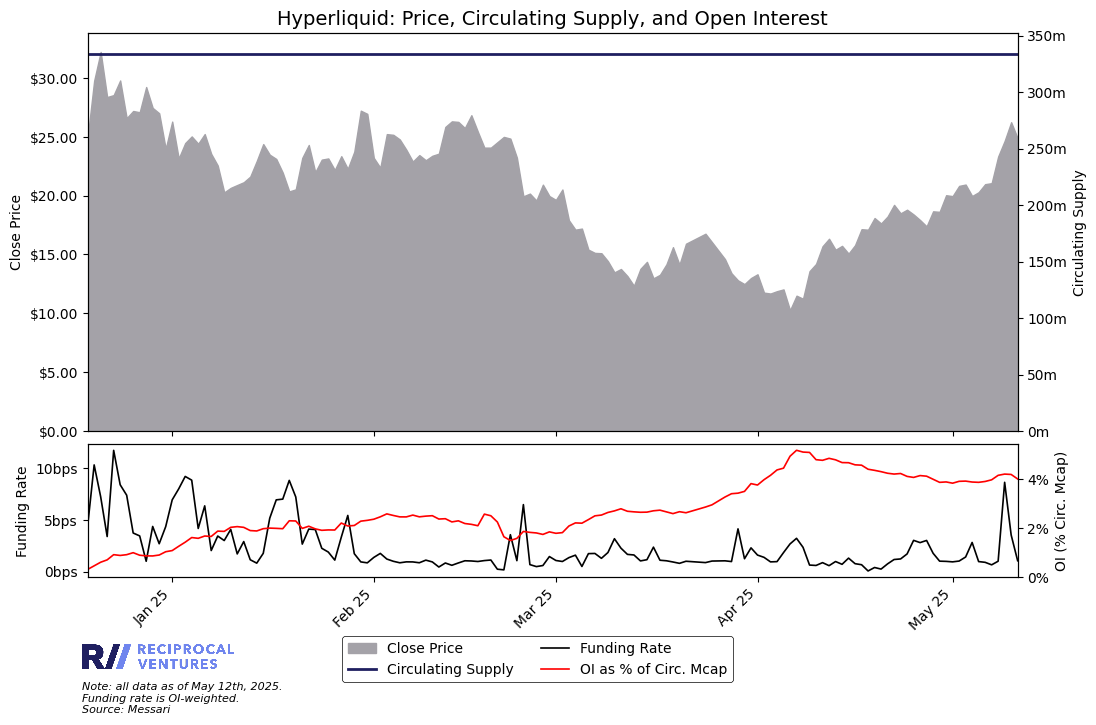

          date      close   close-7d  circulating-supply  \
136 2025-05-07  21.054420  20.568420           333928180   
137 2025-05-08  23.312778  21.048341           333928180   
138 2025-05-09  24.641167  21.593927           333928180   
139 2025-05-10  26.230791  22.350422           333928180   
140 2025-05-11  24.865661  23.050960           333928180   

     circulating-supply-7d  open-interest  open-interest-7d  \
136            333928180.0   2.781224e+08      2.667248e+08   
137            333928180.0   3.221741e+08      2.764055e+08   
138            333928180.0   3.446551e+08      2.869587e+08   
139            333928180.0   3.655938e+08      3.002064e+08   
140            333928180.0   3.313177e+08      3.107296e+08   

     circulating-marketcap  circulating-marketcap-7d  \
136             7030664235              6.868375e+09   
137             7784793374              7.028634e+09   
138             8228379892              7.210821e+09   
139             8759200437          

In [27]:
assets = {'hyperliquid': 'Hyperliquid'}

for asset_id, asset_name in assets.items():
    oi_vs_circulating_mcap_vs_funding_rate(asset_id, asset_name, date)

In [28]:
def annualized_revenue_vs_price_to_annualized_revenue(asset_id, asset_name, start_date, date):
    # Load revenue data
    with open(f"raw-data/defillama-raw-data/defillama_{asset_id}-revenue.json", "r") as f:
        rev_data = json.load(f)
    
    rev_df = pd.DataFrame(rev_data["totalDataChart"], columns=["timestamp", "revenue"])
    rev_df["date"] = pd.to_datetime(rev_df["timestamp"], unit="s")
    rev_df = rev_df[["date", "revenue"]]
    
    # Annualize revenue and calculate trailing 7-day average
    rev_df['annualized-revenue'] = rev_df['revenue'] * 365
    rev_df["annualized-revenue-7d"] = rev_df["annualized-revenue"].rolling(window=7).mean()

    # Load mcap data
    with open(f"raw-data/messari-raw-data/messari_{asset_id}_marketcap.json", 'r') as f:
        mcap_data = json.load(f)
    
    points = mcap_data['data']['points']
    mcap_df = pd.DataFrame(points, columns=[
        'timestamp',
        'circulating-marketcap',
        'circulating-marketcap-dominance',
        'fully-diluted-marketcap'
    ])
    mcap_df["date"] = pd.to_datetime(mcap_df["timestamp"], unit="s")
    mcap_df = mcap_df[['date','fully-diluted-marketcap']]
    mcap_df['FDV-7d'] = mcap_df['fully-diluted-marketcap'].rolling(window=7).mean()
    
    # Merge datasets
    df = pd.merge(rev_df, mcap_df, on="date", how="inner")
    
    # Calculate P/S ratio and trailing 7-day average
    df['FDV-to-annualized-revenue-multiple'] = df['fully-diluted-marketcap'] / df['annualized-revenue']
    df['FDV-to-annualized-revenue-multiple-7d'] = df['FDV-to-annualized-revenue-multiple'].rolling(window=7).mean()

    # Filter the data for a given time period
    plot_df = df[df['date'] >= start_date]
    
    # 6) Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Area: Hyperliquid market share
    ax1.fill_between(
        plot_df["date"], plot_df["annualized-revenue-7d"],
        color="#a4a2a8", alpha=1,
        label="Annualized Revenue"
    )
    ax1.set_ylabel("Annualized Revenue")
    ax1.set_ylim(bottom=0)
    ax1.yaxis.set_major_formatter(
            mtick.FuncFormatter(lambda x, _: f'${x/1e9:,.0f}b'))
    
    # Monthly ticks, lighter crowding
    ax1.xaxis.set_major_locator(YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    
    # Line: FDV / annualzied revenue
    ax2 = ax1.twinx()
    ax2.plot(
        plot_df["date"], plot_df["FDV-to-annualized-revenue-multiple-7d"],
        color="#1f1f60", linewidth=2,
        label="FDV / Annualized Revenue"
    )
    ax2.set_ylabel("FDV / Annualized Revenue")
    ax2.set_ylim(bottom=0)
    ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}x'))

    # no extra padding
    ax1.margins(x=0)
    
    # Title, grid & legend
    ax1.set_title(f"{asset_name}: Annualized Revenue vs. FDV / Annualized Revenue", fontsize=14)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    
    # Save & show
    add_logo(ax1, position=(0.075, -0.21))
    plt.figtext(0.075, -0.04, f"Note: all data as of {date}. All figures are 7-day rolling averages.\nSource: DefiLlama and Messari", ha='left', fontsize=10, style='italic')
    plt.tight_layout()
    plt.savefig(f"plots/{asset_id}-annualized-revenue_vs_FDV-to-annualized-revenue_7d.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Debug print
    print(df.tail(10))

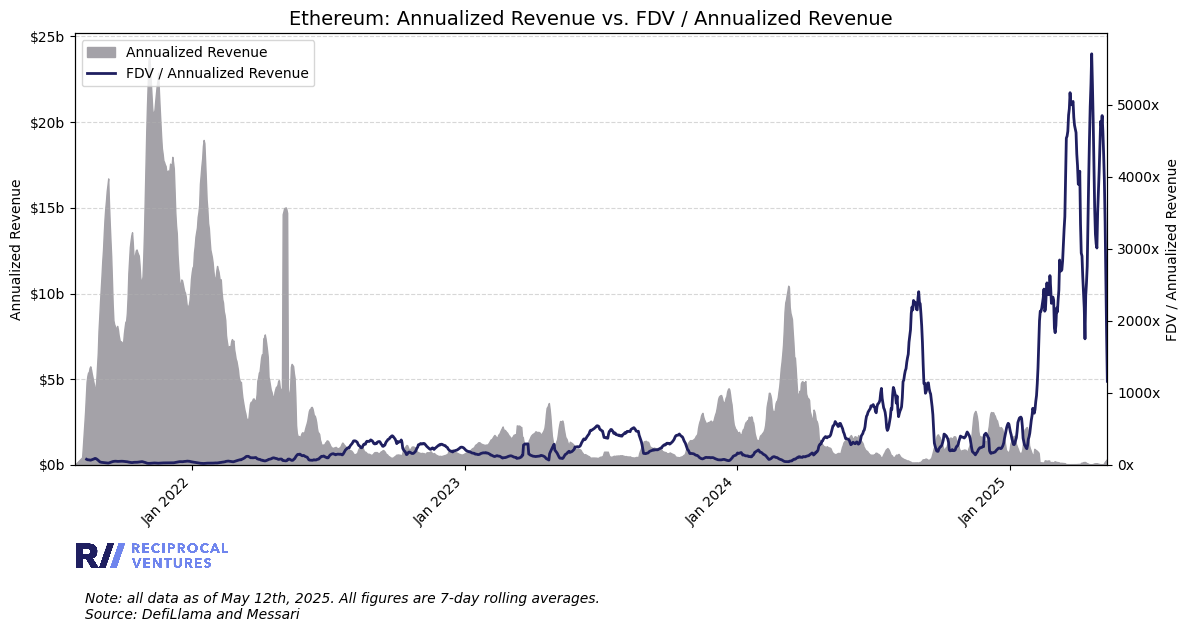

           date  revenue  annualized-revenue  annualized-revenue-7d  \
1367 2025-05-03    92001            33580365           4.890505e+07   
1368 2025-05-04   102785            37516525           4.935202e+07   
1369 2025-05-05   112560            41084400           4.805449e+07   
1370 2025-05-06   187071            68280915           5.126091e+07   
1371 2025-05-07   361307           131877055           6.198138e+07   
1372 2025-05-08  1714597           625827905           1.409367e+08   
1373 2025-05-09  1445809           527720285           2.094125e+08   
1374 2025-05-10   965804           352518460           2.549751e+08   
1375 2025-05-11  1235235           450860775           3.140243e+08   
1376 2025-05-12  1140052           416118980           3.676006e+08   

      fully-diluted-marketcap        FDV-7d  \
1367             2.214863e+11  2.190647e+11   
1368             2.187384e+11  2.194140e+11   
1369             2.197592e+11  2.197647e+11   
1370             2.193012e+11 

In [29]:
assets = {'ethereum': 'Ethereum'}
start_date = '2021-01-01'

for asset_id, asset_name in assets.items():
    annualized_revenue_vs_price_to_annualized_revenue(asset_id, asset_name, start_date, date)

In [25]:
# Funciton for plotting OI as % FDV for a given asset and comparing to BTC

def price_vs_oi(asset_id, asset_name, date):
    # Load price data
    with open(f'raw-data/messari-raw-data/messari_{asset_id}_price.json', 'r') as f:
        price_data = json.load(f)
    
    points = price_data['data']['points']
    price_df = pd.DataFrame(points, columns=[
        'timestamp',
        'open',
        'high',
        'low',
        'close',
        'volume'
    ])
    price_df["date"] = pd.to_datetime(price_df["timestamp"], unit="s")
    price_df = price_df[['date','close']]
    
    # Calculate trailing 7-day average
    price_df['close-7d'] = price_df['close'].rolling(window=7).mean()

    # Load fundring rate data for the asset slug
    with open (f'raw-data/messari-raw-data/messari_{asset_id}_futures-open-interest.json', 'r') as f:
        rate_data = json.load(f)

    points = rate_data['data']['points']
    oi_df = pd.DataFrame(points, columns=[
        'timestamp',
        "open-interest"
    ])
    oi_df['date'] = pd.to_datetime(oi_df['timestamp'], unit='s')
    oi_df = oi_df[['date', 'open-interest']]
    oi_df = oi_df.rename(columns={"open-interest": "oi"})
     # Calculate trailing 7-day average
    oi_df['oi-7d'] = oi_df['oi'].rolling(window=7).mean()

    # Merge datasets for asset slug
    df = pd.merge(price_df, oi_df, on="date", how="inner")

    # 6) Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Area: Price
    ax1.fill_between(
        df["date"], df["close-7d"],
        color="#a4a2a8", alpha=1,
        label=f"{asset_name} Price"
    )
    ax1.yaxis.set_major_formatter(
            mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    
    ax1.set_ylabel("Price")
    ax1.margins(x=0)                  # no extra padding
    ax1.set_ylim(bottom=0)

    # Monthly ticks, lighter crowding
    ax1.xaxis.set_major_locator(MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    
    # Line: OI
    ax2 = ax1.twinx()
    ax2.plot(
        df["date"], df["oi-7d"],
        color="#1f1f60", linewidth=2,
        label=f"{asset_name} OI"
    )
    ax2.set_ylabel("OI")
    ax2.yaxis.set_major_formatter(
            mtick.FuncFormatter(lambda x, _: f'${x/1e6:,.0f}m'))
    
    # Title, grid & legend
    ax1.set_title(f"{asset_name}: Price vs OI", fontsize=14)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")
    
    # Save & show
    add_logo(ax1, position=(0.075, -0.21))
    plt.figtext(0.075, -0.04, f"Note: all data as of {date}. All figures are 7-day rolling averages.\nSource: Messari", ha='left', fontsize=10, style='italic')
    plt.tight_layout()
    plt.savefig(f"plots/{asset_id}_price_vs_oi_7d.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Debug print
    print(df.tail(5))

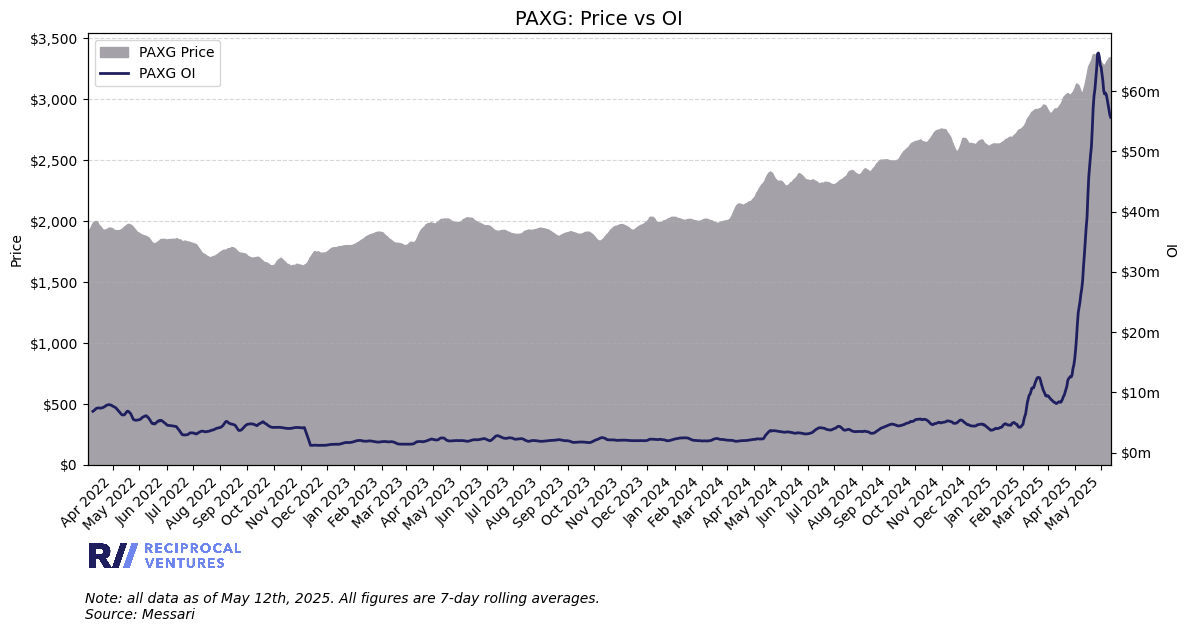

           date        close     close-7d            oi         oi-7d
1162 2025-05-08  3322.132152  3321.490640  5.631585e+07  5.863987e+07
1163 2025-05-09  3335.013901  3333.006682  5.391864e+07  5.776986e+07
1164 2025-05-10  3327.242587  3342.390773  5.215080e+07  5.685825e+07
1165 2025-05-11  3294.356194  3345.724901  5.185294e+07  5.606726e+07
1166 2025-05-12  3242.765772  3330.667168  5.555101e+07  5.563889e+07


In [26]:
assets = {'pax-gold': 'PAXG'}

for asset_id, asset_name in assets.items():
    price_vs_oi(asset_id, asset_name, date)